# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [5]:
''' Complete List of Mice & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_1 excluded, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [6]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

# Edit these paths

In [7]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
int_save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' # adjust to match Shuffle Procedure output plotsave_folder
figs2_folder = 'C:/Users/Python/Desktop/LocalData/FigureS2/' # adjust to match Figure S2 notebook save_folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/ReviewerFigure3/' 

In [8]:
''' Get reward & lick data for sessions w/ neural data'''

#get lick & reward data
rewarda_centers = []
rewardb_centers = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
 
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        d['reward_data'] = {}
        
        # get behavioral params
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 
        
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except:
            skippedtrials = []
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            
        reward_centers = np.array(reward['centers'][keep_idx])
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        auto_reward = np.array(reward['auto'][keep_idx])
        #print('Mouse ' + m + ' with n_misses: ' + str(np.sum(misses)))   

        # get lick and reward indices
        lick_ct = get.spiketrain(post, dt, lickt, index=False)
        d['reward_data']['lick_ct'] = lick_ct
        #print('got lick indices for mouse ' + m + ' session ' + s)
        
        reward_idx = get.rewardtrain(post, dt, rewardt, index=True) #gets reward ct for each time binned position range as index
        d['reward_data']['reward_idx'] = reward_idx
        #print('got reward indices for mouse ' + m + ' session ' + s)
    
    # saves list of reward locations per mouse
    if reward['centers'][0] == 270:
        rewarda_centers = np.append(rewarda_centers,270)
        rewardb_centers = np.append(rewardb_centers,370)
    else:
        rewarda_centers = np.append(rewarda_centers,370)
        rewardb_centers = np.append(rewardb_centers,270)            

In [9]:
''' Find & Save Number of Requested Rewards per Epoch per Session & Animal '''
#session arrays
req_rates = []
reqa_rates = []
reqb_rates = []
reqblock_rates = []
reqalt_rates = []
reqalta_rates = []
reqaltb_rates = []
req_trials = []
reqblock_trials = []
reqalt_trials = []

#animals arrays
mreq_rates = []
mreqa_rates = []
mreqb_rates = []
mreqblock_rates = []
mreqalt_rates = []
mreqalta_rates = []
mreqaltb_rates = []

for m, session in zip(mice, sessions):
    rt = []
    ca = []
    cb = []
    blocks = []
    alt = []
    alta = []
    altb = []
    
    req = []
    reqa = []
    reqb = []
    reqblocks = []
    reqalt = []
    reqalta = []
    reqaltb = []
    
    for s in session:
        # get behavior data
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except:
            skippedtrials = []
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewarda = reward_centers[0]
        rewardb = reward_centers[60]
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        requests = ~misses
        
        # find rate of requests for a given session
        req_rates.append(np.sum(requests)/len(reward_trials)) #total
        
        rewarda_idx = np.where(reward_trials < 81)[0]
        reqa_rates.append(np.sum(requests[rewarda_idx])/len(rewarda_idx)) #context a
        
        rewardb_idx = np.intersect1d((np.where(reward_trials >= 81)), (np.where(reward_trials <= 140)))
        reqb_rates.append(np.sum(requests[rewardb_idx])/len(rewardb_idx)) #context b
        
        block_idx = np.where(reward_trials < 140)[0]
        reqblock_rates.append(np.sum(requests[block_idx])/len(block_idx)) #block
        
        alt_idx = np.where(reward_trials >= 140)[0]
        reqalt_rates.append(np.sum(requests[alt_idx])/len(alt_idx)) #alt
        
        alta_idx = np.where((reward_trials >= 140) & (reward_centers == rewarda))[0] 
        reqalta_rates.append(np.mean(requests[alta_idx]))
        
        altb_idx = np.where((reward_trials >= 140) & (reward_centers == rewardb))[0]
        reqaltb_rates.append(np.mean(requests[altb_idx]))
        
        rt = np.append(rt,len(reward_trials))
        ca = np.append(ca,len(rewarda_idx))
        cb = np.append(cb,len(rewardb_idx))
        blocks = np.append(blocks,len(block_idx))
        alt = np.append(alt,len(alt_idx))
        alta = np.append(alta, len(alta_idx))
        altb = np.append(altb, len(altb_idx))
        
        req_trials = np.append(req_trials, len(reward_trials))
        reqblock_trials = np.append(reqblock_trials, len(block_idx))
        reqalt_trials = np.append(reqalt_trials, len(alt_idx))
        
        req = np.append(req,np.sum(requests))
        reqa = np.append(reqa,np.sum(requests[rewarda_idx]))
        reqb = np.append(reqb,np.sum(requests[rewardb_idx]))
        reqblocks = np.append(reqblocks,np.sum(requests[block_idx]))
        reqalt = np.append(reqalt,np.sum(requests[alt_idx]))
        reqalta = np.append(reqalta,requests[alta_idx])
        reqaltb = np.append(reqaltb,requests[altb_idx])
        
        d['altreqbytrial'] = requests[alt_idx]
                               
    # get mouse request rate collapsing days
    mreqrate = np.sum(req)/ np.sum(rt)
    mreq_rates = np.append(mreq_rates,mreqrate)
    
    mreqarate = np.sum(reqa) / np.sum(ca)
    mreqa_rates = np.append(mreqa_rates, mreqarate)
    
    mreqbrate = np.sum(reqb) / np.sum(cb)
    mreqb_rates = np.append(mreqb_rates, mreqbrate)
    
    mreqblockrate = np.sum(reqblocks) / np.sum(blocks)
    mreqblock_rates = np.append(mreqblock_rates, mreqblockrate)
    
    mreqaltrate = np.sum(reqalt) / np.sum(alt)
    mreqalt_rates = np.append(mreqalt_rates, mreqaltrate)
    
    mreqalta_rates = np.append(mreqalta_rates, np.mean(reqalta))
    mreqaltb_rates = np.append(mreqaltb_rates, np.mean(reqaltb))
    
# save as arrays to be safe
req_rates = np.asarray(req_rates)
reqa_rates = np.asarray(reqa_rates)
reqb_rates = np.asarray(reqb_rates)
reqblock_rates = np.asarray(reqblock_rates)
reqalt_rates = np.asarray(reqalt_rates)
reqalta_rates = np.asarray(reqalta_rates)
reqaltb_rates = np.asarray(reqaltb_rates)

mreq_rates = np.asarray(mreq_rates)
mreqa_rates = np.asarray(mreqa_rates)
mreqb_rates = np.asarray(mreqb_rates)
mreqblock_rates = np.asarray(mreqblock_rates)
mreqalt_rates = np.asarray(mreqalt_rates)
mreqalta_rates = np.asarray(reqalta_rates)
mreqaltb_rates = np.asarray(reqaltb_rates)

In [10]:
''' Load indices corresponding to quarters of the task sorted by context, making sure skipped trials are excluded.

Generated in Figure S2 notebook. Please run that before proceeding.

''' 

for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
        
        #save indices for session sections
        Aidx_file = 'Aidx_' + m + '_' + s +'.npy'
        Bidx_file = 'Bidx_' + m + '_' + s +'.npy'
        A_idx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_idx_file = 'B_idx_' + m + '_' + s +'.npy'
        A_ngidx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_ngidx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        Aidx = np.load(figs2_folder + Aidx_file)
        Bidx = np.load(figs2_folder + Bidx_file)
        A_idx = np.load(figs2_folder + A_idx_file)
        B_idx = np.load(figs2_folder + B_idx_file)
        
        d['Aidx'] = Aidx
        d['Bidx'] = Bidx
        d['A_idx'] = A_idx
        d['B_idx'] = B_idx

        #Also load A`& B` indices excluding gain change trials in each context
        A_ngidx = np.load(figs2_folder + A_ngidx_file)
        B_ngidx = np.load(figs2_folder + B_ngidx_file)
        
        d['A_ngidx'] = A_ngidx
        d['B_ngidx'] = B_ngidx

In [11]:
''' Gather total number of SM cells'''

young_count = 0
MA_count = 0
age_count = 0

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        if m in SM_aged_mice:
            age_count += len(cell_IDs)
        elif m in SM_MA_mice:
            MA_count += len(cell_IDs)
        else:
            young_count += len(cell_IDs)
            
print(young_count, MA_count, age_count)

15152 15011 13225


# Load classified grid, non-grid spatial, and spatial cells in Figure S2.

In [12]:
''' In the Figure S2 notebook, you previously classified grid & ngs cells. Load saved grid & ngs cell booleans.

If you did not, run Figure S2 notebook before proceeding.

'''

pergrid = []
perngs = []

spergrid = []
sperngs = []
mpergrid = []

for m, session in zip(mice,sessions):
    
    m_pergrid = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')

        #load spatial cells & interneuron booleans
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        d['spatialcell99'] = np.load(figs2_folder + spatialcell99_file, allow_pickle = True)
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        
        #load grid & NGS cell booleans
        gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        gridcell = np.load(figs2_folder + gridcell_file)
        
        ngscell_file = 'bordercell__' + m + '_' + s + '.npy'
        ngscell = np.load(figs2_folder + ngscell_file)
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        d['gridcell'] = gridcell
        d['ngscell'] = ngscell
        
        print(m + ', ' + s + ' n grid, ngs cells: '+ str(np.sum(gridcell)) + ' , ' + str(np.sum(ngscell)))
        perngs = np.append(perngs, 100*np.sum(ngscell)/len(cell_IDs))
        pergrid = np.append(pergrid, 100*np.sum(gridcell)/len(cell_IDs))
        
        sperngs = np.append(sperngs, 100*np.sum(ngscell)/len(cell_IDs))
        spergrid = np.append(spergrid, 100*np.sum(gridcell)/len(cell_IDs))
        m_pergrid = np.append(m_pergrid, np.sum(gridcell))
        m_cells = np.append(m_cells, len(cell_IDs))
      
    mpergrid = np.append(mpergrid, np.sum(m_pergrid)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n grid, ngs cells: 8 , 50
A14, 083122_record2 n grid, ngs cells: 35 , 2
A14, 090122_record3 n grid, ngs cells: 17 , 13


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n grid, ngs cells: 4 , 6
A15, 083122_record2 n grid, ngs cells: 86 , 33
A15, 090122_record3 n grid, ngs cells: 89 , 37
A15, 090222_record4 n grid, ngs cells: 128 , 65
A15, 090322_record5 n grid, ngs cells: 37 , 30
A15, 090422_record6 n grid, ngs cells: 24 , 19


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n grid, ngs cells: 19 , 23
A16, 083122_record2 n grid, ngs cells: 60 , 36
A16, 090122_record3 n grid, ngs cells: 0 , 1
A16, 090222_record4 n grid, ngs cells: 12 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n grid, ngs cells: 1 , 2
A17, 082422_record2 n grid, ngs cells: 2 , 6
A17, 082522_record3 n grid, ngs cells: 40 , 35
A17, 082622_record4 n grid, ngs cells: 42 , 17
A17, 082722_record5 n grid, ngs cells: 32 , 21
A17, 082822_record6 n grid, ngs cells: 54 , 25


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n grid, ngs cells: 13 , 10
A18, 082422_record2 n grid, ngs cells: 66 , 169
A18, 082522_record3 n grid, ngs cells: 68 , 117
A18, 082622_record4 n grid, ngs cells: 44 , 64
A18, 082722_record5 n grid, ngs cells: 47 , 10
A18, 082822_record6 n grid, ngs cells: 0 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n grid, ngs cells: 17 , 1
A19, 012823_record3 n grid, ngs cells: 22 , 75
A19, 012923_record4 n grid, ngs cells: 34 , 64
A19, 013023_record5 n grid, ngs cells: 54 , 38
A19, 013123_record6 n grid, ngs cells: 35 , 18
A19, 020123_record7 n grid, ngs cells: 54 , 31


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n grid, ngs cells: 3 , 18
A20, 012723_record2 n grid, ngs cells: 24 , 50
A20, 012823_record3 n grid, ngs cells: 69 , 56
A20, 012923_record4 n grid, ngs cells: 21 , 42
A20, 013023_record5 n grid, ngs cells: 22 , 55
A20, 013123_record6 n grid, ngs cells: 9 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n grid, ngs cells: 58 , 39
A22, 013023_record3 n grid, ngs cells: 79 , 122
A22, 013123_record4 n grid, ngs cells: 55 , 46
A22, 020123_record5 n grid, ngs cells: 10 , 12
A22, 020223_record6 n grid, ngs cells: 31 , 38
A22, 020323_record7 n grid, ngs cells: 12 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n grid, ngs cells: 4 , 10
A23, 021023_record2 n grid, ngs cells: 27 , 63
A23, 021123_record3 n grid, ngs cells: 29 , 66
A23, 021223_record4 n grid, ngs cells: 9 , 3
A23, 021323_record5 n grid, ngs cells: 27 , 38
A23, 021423_record6 n grid, ngs cells: 50 , 54


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n grid, ngs cells: 41 , 34
A24, 022723_record2 n grid, ngs cells: 108 , 65
A24, 022823_record3 n grid, ngs cells: 61 , 63
A24, 030123_record4 n grid, ngs cells: 66 , 37
A24, 030223_record5 n grid, ngs cells: 53 , 26
A24, 030323_record6 n grid, ngs cells: 20 , 19


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n grid, ngs cells: 69 , 91
MA10F, 111422_record2 n grid, ngs cells: 52 , 48
MA10F, 111522_record3 n grid, ngs cells: 38 , 24
MA10F, 111622_record4 n grid, ngs cells: 19 , 24
MA10F, 111722_record5 n grid, ngs cells: 17 , 28
MA10F, 111822_record6 n grid, ngs cells: 39 , 61


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n grid, ngs cells: 33 , 25
MA1F, 102422_record2 n grid, ngs cells: 53 , 28
MA1F, 102522_record3 n grid, ngs cells: 48 , 21
MA1F, 102622_record4 n grid, ngs cells: 9 , 8
MA1F, 102722_record5 n grid, ngs cells: 71 , 52
MA1F, 102822_record6 n grid, ngs cells: 72 , 28


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n grid, ngs cells: 47 , 76
MA2F, 102422_record2 n grid, ngs cells: 38 , 103
MA2F, 102522_record3 n grid, ngs cells: 50 , 110
MA2F, 102622_record4 n grid, ngs cells: 39 , 65
MA2F, 102722_record5 n grid, ngs cells: 38 , 43
MA2F, 102822_record6 n grid, ngs cells: 40 , 49


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n grid, ngs cells: 6 , 22
MA3M, 102422_record2 n grid, ngs cells: 28 , 53
MA3M, 102522_record3 n grid, ngs cells: 36 , 47
MA3M, 102622_record4 n grid, ngs cells: 13 , 55
MA3M, 102722_record5 n grid, ngs cells: 12 , 30
MA3M, 102822_record6 n grid, ngs cells: 31 , 39


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n grid, ngs cells: 24 , 68
MA4M, 110122_record3 n grid, ngs cells: 29 , 27
MA4M, 110222_record4 n grid, ngs cells: 8 , 13
MA4M, 110322_record5rep n grid, ngs cells: 26 , 18
MA4M, 110422_record6 n grid, ngs cells: 36 , 35
MA4M, 110522_record7 n grid, ngs cells: 12 , 9


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n grid, ngs cells: 58 , 30
MA5M, 110722_record2 n grid, ngs cells: 62 , 55
MA5M, 110822_record3 n grid, ngs cells: 79 , 30
MA5M, 110922_record4 n grid, ngs cells: 7 , 11
MA5M, 111022_record5 n grid, ngs cells: 23 , 25
MA5M, 111122_record6 n grid, ngs cells: 22 , 23


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n grid, ngs cells: 22 , 75
MA6M, 103122_record2 n grid, ngs cells: 17 , 39
MA6M, 110122_record3 n grid, ngs cells: 64 , 66
MA6M, 110222_record4 n grid, ngs cells: 7 , 13
MA6M, 110322_record5 n grid, ngs cells: 10 , 6
MA6M, 110422_record6 n grid, ngs cells: 39 , 31


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n grid, ngs cells: 31 , 36
MA7M, 103122_record2 n grid, ngs cells: 32 , 56
MA7M, 110122_record3 n grid, ngs cells: 19 , 28
MA7M, 110222_record4 n grid, ngs cells: 7 , 7


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n grid, ngs cells: 19 , 8
MA8F, 111422_record2 n grid, ngs cells: 62 , 67
MA8F, 111522_record3 n grid, ngs cells: 80 , 26
MA8F, 111622_record4 n grid, ngs cells: 25 , 37
MA8F, 111722_record5 n grid, ngs cells: 10 , 29
MA8F, 111822_record6 n grid, ngs cells: 12 , 20


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n grid, ngs cells: 56 , 29
MA9F, 111422_record2 n grid, ngs cells: 73 , 169
MA9F, 111522_record3 n grid, ngs cells: 119 , 80
MA9F, 111622_record4 n grid, ngs cells: 0 , 1
MA9F, 111722_record5 n grid, ngs cells: 24 , 34
MA9F, 111822_record6 n grid, ngs cells: 23 , 16


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n grid, ngs cells: 7 , 7
Y20, 092622_record2 n grid, ngs cells: 32 , 39
Y20, 092722_record3 n grid, ngs cells: 13 , 10
Y20, 092822_record4 n grid, ngs cells: 51 , 33
Y20, 092922_record5 n grid, ngs cells: 19 , 14
Y20, 093022_record6 n grid, ngs cells: 85 , 64


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n grid, ngs cells: 103 , 76
Y21, 091922_record2 n grid, ngs cells: 80 , 93
Y21, 092022_record3 n grid, ngs cells: 49 , 23
Y21, 092122_record4 n grid, ngs cells: 60 , 62
Y21, 092222_record5 n grid, ngs cells: 42 , 50
Y21, 092322_record6 n grid, ngs cells: 8 , 21


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n grid, ngs cells: 85 , 57
Y22, 092622_record2 n grid, ngs cells: 146 , 66
Y22, 092722_record3 n grid, ngs cells: 60 , 84
Y22, 092822_record4 n grid, ngs cells: 24 , 21
Y22, 092922_record5 n grid, ngs cells: 20 , 25
Y22, 093022_record6 n grid, ngs cells: 60 , 36


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n grid, ngs cells: 38 , 27
Y23, 092622_record2 n grid, ngs cells: 33 , 23
Y23, 092722_record3 n grid, ngs cells: 30 , 40
Y23, 092822_record4 n grid, ngs cells: 26 , 32
Y23, 092922_record5 n grid, ngs cells: 41 , 49
Y23, 093022_record6 n grid, ngs cells: 60 , 84


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n grid, ngs cells: 91 , 64
Y24, 091922_record2 n grid, ngs cells: 28 , 69
Y24, 092022_record3 n grid, ngs cells: 97 , 49
Y24, 092122_record4 n grid, ngs cells: 94 , 64
Y24, 092222_record5 n grid, ngs cells: 66 , 44
Y24, 092322_record6 n grid, ngs cells: 70 , 43


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n grid, ngs cells: 0 , 1
Y25, 021723_record2 n grid, ngs cells: 85 , 37
Y25, 021823_record3 n grid, ngs cells: 29 , 64
Y25, 021923_record4 n grid, ngs cells: 38 , 49
Y25, 022023_record5 n grid, ngs cells: 49 , 46
Y25, 022123_record6 n grid, ngs cells: 18 , 17


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n grid, ngs cells: 34 , 47
Y26, 021723_record2 n grid, ngs cells: 51 , 22
Y26, 021823_record3 n grid, ngs cells: 23 , 32
Y26, 021923_record4 n grid, ngs cells: 2 , 2
Y26, 022023_record5 n grid, ngs cells: 17 , 19
Y26, 022123_record6 n grid, ngs cells: 4 , 3


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n grid, ngs cells: 53 , 44
Y27, 021723_record2 n grid, ngs cells: 39 , 17
Y27, 021823_record3 n grid, ngs cells: 31 , 18
Y27, 021923_record4 n grid, ngs cells: 19 , 20
Y27, 022023_record5rep n grid, ngs cells: 48 , 26
Y27, 022123_record6 n grid, ngs cells: 65 , 30


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n grid, ngs cells: 4 , 32
Y28, 022723_record2 n grid, ngs cells: 41 , 58
Y28, 022823_record3 n grid, ngs cells: 48 , 45
Y28, 030123_record4 n grid, ngs cells: 20 , 33
Y28, 030223_record5 n grid, ngs cells: 40 , 75
Y28, 030323_record6 n grid, ngs cells: 65 , 48


In [13]:
''' Get counts of grid vs ngs cells by age group '''

ygrid = 0
magrid = 0
agrid = 0

yngs = 0
mangs = 0
angs = 0 

for m, session in zip(mice,sessions):    
    for s in session:
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        gridcell = d['gridcell']
        ngscell = d['ngscell']
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        
        if m in SM_aged_mice:
            agrid += np.sum(gridcell)
            angs += np.sum(ngscell)
        elif m in SM_MA_mice:
            magrid += np.sum(gridcell)
            mangs += np.sum(ngscell)
        else:
            ygrid += np.sum(gridcell)
            yngs += np.sum(ngscell)
            
print(ygrid, magrid, agrid)
print(yngs, mangs, angs)

2441 2035 2032
2154 2347 2058


Mean, SEM Grid Cell %; Mean, Sem NGS Cell %
14.8296889586848 0.6177677242640354 15.167797844277539 0.5583139064062825


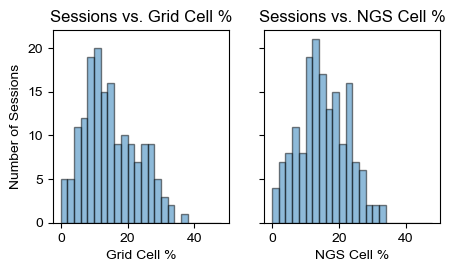

In [14]:
''' Examine grid & NGS cell densities quickly as a sanity check'''

# Assess distribution of grid/ngs cell densities
print('Mean, SEM Grid Cell %; Mean, Sem NGS Cell %')
print(np.mean(pergrid), stats.sem(pergrid), np.mean(perngs), stats.sem(perngs))

#plot grid vs. ngs cell % distributions
fig, ax = plt.subplots(1,2,figsize = (5,2.5), sharey = True)
ax[0].hist(pergrid, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[0].set_title('Sessions vs. Grid Cell %')
ax[0].set_ylabel('Number of Sessions')
ax[0].set_xlabel('Grid Cell %')

ax[1].hist(perngs, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[1].set_title('Sessions vs. NGS Cell %')
ax[1].set_xlabel('NGS Cell %')

plt.show()

In [15]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[ma_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

['Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28'] ['MA10F' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F'] ['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24']
9 10 10
54 58 55


In [16]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in SM_aged_mice:
            idx = np.where(mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in SM_MA_mice:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - (Nold + Nma)
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# set up handles
from itertools import repeat
per99 = [mpergrid[y_ind], mpergrid[ma_ind], mpergrid[age_ind]]
handles = []

for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        
        if c[0] == col_animal[0][0][8][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.append(l)

# Examine Reward Zone Over-Representation (Reviewer Figure 3)

A reviewer suggested we analyze reward zone firing rate (FR) dynamics of position-tuned cells in MEC in our dataset. Below, we show analyses that investigated whether age modulated Split Maze (SM) reward zone “overrepresentation” at both long (across session) and short (within session) timescales in both grid and non-grid spatial (NGS) cells. For each grid and NGS cell, on each trial, we calculated the mean normalized firing rate (FR) over reward zone spatial bins (see Methods), as an estimate of reward zone “representation” among MEC spatial cell firing fields. 

Previous data suggests that CA1 place fields and MEC grid fields independently overrepresent goal locations, and that this is positively correlated with memory retention (Boccara et al. 2019). Butler et al. (2019) reported subsets of non-grid spatial cells formed a clear spatial field near the goal. We sought to understand if this sort of reward coding plasticity is impaired in aging and, if so, if such deficits related to impaired performance in the Split Maze spatial memory task.

In [18]:
''' 
For both grid & NGS cells, across age groups: 

a. Find reward zone FR on each trial, normalized to peak & min FR for each cell. 
b. Then, calculate fold change in norm rzFR (post - pre) in each session during block trials (akin to learning) (dFR)
- Mean "pre learning" rzFR (first 5 trials / context) during block
- Mean "post learning" rzFR (last 5 trials / context) during block
c. Also, calculate mean block reward zone FR & mean alt. reward zone FR across trials in each session for each cell. (rzFR)

Run time: < 1 min / session x 167 sessions. 

'''
#cell arrays
alldFR_grid = []
alldFR_ngs = []
allpre_grid = []
allpre_ngs = []
allpost_grid = []
allpost_ngs = []
allblock_grid = []
allblock_ngs = []
allalt_grid = []
allalt_ngs = []

#session arrays
sdFR_grid = []
sdFR_ngs = []
spre_grid = []
spre_ngs = []
spost_grid = []
spost_ngs = []
sblock_grid = []
sblock_ngs = []
salt_grid = []
salt_ngs = []

for m, session in zip(mice, sessions):
    
    for s in tdqm(session):
        d = data[m][s]
                
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)
        
        #calculate normalized FR, sorting alt trials by context, trimming dark & end frames
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
        else:
            end_idx = len(skippedrawtrialfil) + 1
        FR, binnedpos, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        
        #find reward zone centers 
        reward = raw.item().get('reward')
        centers = reward['centers']
        centera = centers[0]
        if centera == 270:
            centerb = 370
        else:
            centerb = 270
        
        #find boolean mask indices of reward zones position bins on Context A/B trials 
        aidx = np.where((binnedpos > (centera - 25)) & (binnedpos <= (centera + 25)))
        maska = np.zeros(len(binnedpos), bool)
        maska[aidx] = 1
        
        bidx = np.where((binnedpos > (centerb - 25)) & (binnedpos <= (centerb + 25)))
        maskb = np.zeros(len(binnedpos), bool)
        maskb[bidx] = 1
        
        #load indices of observations by VR trial block, excluding A' and B' gain change trials
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))

        # analyze grid cell reward zone firing 
        grid_meanpre = []
        grid_meanpost = []
        grid_dFR = [] # abs % difference in mean reward zone FR (post - pre) 
        grid_meanblock = []
        grid_meanalt = []
        
        for i, c in enumerate(gridcells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int) 
            cellFR = FR[:,:,sdx]
                
            # find normalized reward zone FR by trial
            Blockpre = [] # reward zone FR in first 10 block trials (5 first trials / context)
            Blockpost = [] # reward zone FR in first 10 block trials (5 last trials / context)
            BlockrzFR = [] #reward zone FR for all block trials
            AltrzFR = [] #reward zone FR for all alt trials
            
            for t in range(cellFR.shape[0]):
                
                if (t < lengthA): # block A rewards 
                    rzFR = np.mean(cellFR[t,maska])
                    BlockrzFR = np.append(BlockrzFR, rzFR)
                    
                    if t < 5:
                        Blockpre = np.append(Blockpre, rzFR)
                    
                    if (t >= (lengthA - 5)):
                        Blockpost = np.append(Blockpost, rzFR)
                        
                    #print(str(c) + ' Block A, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
                elif (t >= lengthA) & (t < (lengthA + lengthB)): # block B rewards
                    rzFR = np.mean(cellFR[t,maskb])
                    BlockrzFR = np.append(BlockrzFR, rzFR)
                    
                    if t < (5 + lengthA):
                        Blockpre = np.append(Blockpre, rzFR)
                    
                    if (t >= ((lengthA + lengthB) - 5)):
                        Blockpost = np.append(Blockpost, rzFR)
                    
                    #print(str(c) + ' Block B, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
                elif (t >= (lengthA + lengthB)) & (t < (lengthA + lengthB + lengthA_)): #block A` rewards excl. gain change
                    rzFR = np.mean(cellFR[t,maska])
                    AltrzFR = np.append(AltrzFR, rzFR)
                    #print(str(c) + ' Block A`, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
                elif (t >= (lengthA + lengthB + lengtha_)) & (t < (lengthA + lengthB + lengtha_ + lengthB_)): # block B` rewards excl. gain change
                    rzFR = np.mean(cellFR[t,maskb])
                    AltrzFR = np.append(AltrzFR, rzFR)
                    
                    #print(str(c) + ' Block B`, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
            
            # save out mean pre, post, % diff post-pre reward zone FR, mean block, mean alt firing by cell 
            grid_meanpre = np.append(grid_meanpre, np.mean(Blockpre))
            grid_meanpost = np.append(grid_meanpost, np.mean(Blockpost))
            grid_meanblock = np.append(grid_meanblock, np.mean(BlockrzFR))
            grid_meanalt = np.append(grid_meanalt, np.mean(AltrzFR))
            grid_dFR = np.append(grid_dFR, (np.mean(Blockpost) - np.mean(Blockpre)) / ((np.mean(Blockpost) + np.mean(Blockpre))/2)*100)
        
        # analyze ngs cell reward zone firing         
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell] 
        
        ngs_meanpre = []
        ngs_meanpost = []
        ngs_dFR = [] # abs % difference in mean reward zone FR (post - pre) 
        ngs_meanblock = []
        ngs_meanalt = []

        for i, c in enumerate(ngscells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int) 
            cellFR = FR[:,:,sdx]
                
            # find normalized reward zone FR by trial
            Blockpre = [] # reward zone FR in first 10 block trials (5 first trials / context)
            Blockpost = [] # reward zone FR in first 10 block trials (5 last trials / context)
            BlockrzFR = [] #reward zone FR for all block trials
            AltrzFR = [] #reward zone FR for all alt trials
            
            for t in range(cellFR.shape[0]):
                
                if (t < lengthA): # block A rewards 
                    rzFR = np.mean(cellFR[t,maska])
                    BlockrzFR = np.append(BlockrzFR, rzFR)
                    
                    if t < 5:
                        Blockpre = np.append(Blockpre, rzFR)
                    
                    if (t >= (lengthA - 5)):
                        Blockpost = np.append(Blockpost, rzFR)
                        
                    #print(str(c) + ' Block A, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
                elif (t >= lengthA) & (t < (lengthA + lengthB)): # block B rewards
                    rzFR = np.mean(cellFR[t,maskb])
                    BlockrzFR = np.append(BlockrzFR, rzFR)
                    
                    if t < (5 + lengthA):
                        Blockpre = np.append(Blockpre, rzFR)
                    
                    if (t >= ((lengthA + lengthB) - 5)):
                        Blockpost = np.append(Blockpost, rzFR)
                    
                    #print(str(c) + ' Block B, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
                elif (t >= (lengthA + lengthB)) & (t < (lengthA + lengthB + lengthA_)): #block A` rewards excl. gain change
                    rzFR = np.mean(cellFR[t,maska])
                    AltrzFR = np.append(AltrzFR, rzFR)
                    #print(str(c) + ' Block A`, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
                elif (t >= (lengthA + lengthB + lengtha_)) & (t < (lengthA + lengthB + lengtha_ + lengthB_)): # block B` rewards excl. gain change
                    rzFR = np.mean(cellFR[t,maskb])
                    AltrzFR = np.append(AltrzFR, rzFR)
                    
                    #print(str(c) + ' Block B`, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
            
            # save out mean pre, post, % diff post-pre reward zone FR, mean block, mean alt firing by cell 
            ngs_meanpre = np.append(ngs_meanpre, np.mean(Blockpre))
            ngs_meanpost = np.append(ngs_meanpost, np.mean(Blockpost))
            ngs_meanblock = np.append(ngs_meanblock, np.mean(BlockrzFR))
            ngs_meanalt = np.append(ngs_meanalt, np.mean(AltrzFR))
            ngs_dFR = np.append(ngs_dFR, (np.mean(Blockpost) - np.mean(Blockpre)) / ((np.mean(Blockpost) + np.mean(Blockpre))/2)*100)
                                                           
        #save out cell & session data for grid cells
        alldFR_grid = np.append(alldFR_grid, grid_dFR)
        alldFR_ngs = np.append(alldFR_ngs, ngs_dFR)
        allpre_grid = np.append(allpre_grid, grid_meanpre)
        allpre_ngs = np.append(allpre_ngs,ngs_meanpre)
        allpost_grid = np.append(allpost_grid, grid_meanpost)
        allpost_ngs = np.append(allpost_ngs, ngs_meanpost)
        allblock_grid = np.append(allblock_grid, grid_meanblock)
        allblock_ngs = np.append(allblock_ngs, ngs_meanblock)
        allalt_grid = np.append(allalt_grid, grid_meanalt)
        allalt_ngs = np.append(allalt_ngs, ngs_meanalt)

        #session arrays
        sdFR_grid = np.append(sdFR_grid, np.mean(grid_dFR))
        sdFR_ngs = np.append(sdFR_ngs, np.mean(ngs_dFR))
        spre_grid = np.append(spre_grid, np.mean(grid_meanpre))
        spre_ngs = np.append(spre_ngs, np.mean(ngs_meanpre))
        spost_grid = np.append(spost_grid, np.mean(grid_meanpost))
        spost_ngs = np.append(spost_ngs, np.mean(ngs_meanpost))
        sblock_grid = np.append(sblock_grid, np.mean(grid_meanblock))
        sblock_ngs = np.append(sblock_ngs, np.mean(ngs_meanalt))
        salt_grid = np.append(salt_grid, np.mean(grid_meanalt))
        salt_ngs = np.append(salt_ngs, np.mean(ngs_meanalt))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
''' Index Young, MA, & Aged Cells '''

#Find number of young, MA, aged cells of each type
ygridcells = np.zeros(len(alldFR_grid),bool)
magridcells = np.zeros(len(alldFR_grid),bool)
agedgridcells = np.zeros(len(alldFR_grid),bool)

yngscells = np.zeros(len(alldFR_ngs),bool)
mangscells = np.zeros(len(alldFR_ngs),bool)
agedngscells = np.zeros(len(alldFR_ngs),bool)

totalgridcells = 0
totalngscells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        for k, c in enumerate(gridcells):
            
            if m in SM_aged_mice:
                agedgridcells[totalgridcells] = 1
            elif m in SM_MA_mice:
                magridcells[totalgridcells] = 1
            else:
                 ygridcells[totalgridcells] = 1      
            
            totalgridcells += 1
            
        for j, c in enumerate(ngscells):
            
            if m in SM_aged_mice:
                agedngscells[totalngscells] = 1
            elif m in SM_MA_mice:
                mangscells[totalngscells] = 1
            else:
                 yngscells[totalngscells] = 1      
            
            totalngscells += 1
            
grid_n_y = np.sum(ygridcells)
grid_n_ma = np.sum(magridcells)
grid_n_aged = np.sum(agedgridcells)

ngs_n_y = np.sum(yngscells)
ngs_n_ma = np.sum(mangscells)
ngs_n_aged = np.sum(agedngscells)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [22]:
'''Statistically Compare (across Age Groups at Cell Level) Block & Alt RZ FR'''

#AGE GROUP DIFFERENCES WITHIN CELL TYPE
# grid rz firing rate (block)
print('\nBLOCK GRID CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(allblock_grid[ygridcells], allblock_grid[magridcells], allblock_grid[agedgridcells])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')

# grid rz firing rate (alt)
print('\nALT GRID CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(allalt_grid[ygridcells], allalt_grid[magridcells], allalt_grid[agedgridcells])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')

# ngs rz firing rate (block)
print('\nBLOCK NGS CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(allblock_ngs[yngscells], allblock_ngs[mangscells], allblock_ngs[agedngscells])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')

# ngs rz firing rate (alt)
print('\nALT NGS CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(allalt_ngs[yngscells], allalt_ngs[mangscells], allalt_ngs[agedngscells])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')

#STATS on block FR (MEAN ± SEM) for GRID CELLS
print('\nGRID CELL Block INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(allblock_grid[ygridcells]),3)) + ' ± '  + str(np.round(stats.sem(allblock_grid[ygridcells]),3)))
print(str(np.round(np.mean(allblock_grid[magridcells]),3)) + ' ± '  + str(np.round(stats.sem(allblock_grid[magridcells]),3)))
print(str(np.round(np.mean(allblock_grid[agedgridcells]),3)) + ' ± '  + str(np.round(stats.sem(allblock_grid[agedgridcells]),3)))

print('\nNGS CELL Block INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(allblock_ngs[yngscells]),3)) + ' ± '  + str(np.round(stats.sem(allblock_ngs[yngscells]),3)))
print(str(np.round(np.mean(allblock_ngs[mangscells]),3)) + ' ± '  + str(np.round(stats.sem(allblock_ngs[mangscells]),3)))
print(str(np.round(np.mean(allblock_ngs[agedngscells]),3)) + ' ± '  + str(np.round(stats.sem(allblock_ngs[agedngscells]),3)))

print('\nGRID CELL Alt INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(allalt_grid[ygridcells]),3)) + ' ± '  + str(np.round(stats.sem(allalt_grid[ygridcells]),3)))
print(str(np.round(np.mean(allalt_grid[magridcells]),3)) + ' ± '  + str(np.round(stats.sem(allalt_grid[magridcells]),3)))
print(str(np.round(np.mean(allalt_grid[agedgridcells]),3)) + ' ± '  + str(np.round(stats.sem(allalt_grid[agedgridcells]),3)))

print('\nNGS CELL Alt INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(allalt_ngs[yngscells]),3)) + ' ± '  + str(np.round(stats.sem(allalt_ngs[yngscells]),3)))
print(str(np.round(np.mean(allalt_ngs[mangscells]),3)) + ' ± '  + str(np.round(stats.sem(allalt_ngs[mangscells]),3)))
print(str(np.round(np.mean(allalt_ngs[agedngscells]),3)) + ' ± '  + str(np.round(stats.sem(allalt_ngs[agedngscells]),3)))


BLOCK GRID CHANGE IN FIRING RATE:
rate remapping (Kruskal): H = 5.578
rate remapping (Kruskal): p = 0.06148

ALT GRID CHANGE IN FIRING RATE:
rate remapping (Kruskal): H = 5.714
rate remapping (Kruskal): p = 0.05745

BLOCK NGS CHANGE IN FIRING RATE:
rate remapping (Kruskal): H = 4.247
rate remapping (Kruskal): p = 0.1196

ALT NGS CHANGE IN FIRING RATE:
rate remapping (Kruskal): H = 24.9
rate remapping (Kruskal): p = 3.923e-06

GRID CELL Block INFO:
young mean ± SEM, MA mean ± SEM, aged mean ± SEM: 
0.101 ± 0.001
0.099 ± 0.002
0.1 ± 0.002

NGS CELL Block INFO:
young mean ± SEM, MA mean ± SEM, aged mean ± SEM: 
0.122 ± 0.002
0.126 ± 0.002
0.128 ± 0.002

GRID CELL Alt INFO:
young mean ± SEM, MA mean ± SEM, aged mean ± SEM: 
0.09 ± 0.001
0.091 ± 0.001
0.095 ± 0.001

NGS CELL Alt INFO:
young mean ± SEM, MA mean ± SEM, aged mean ± SEM: 
0.107 ± 0.002
0.113 ± 0.002
0.119 ± 0.002


In [23]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Grid Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
            
        for j, c in enumerate(gridcells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     rzFRblock
No. Observations:       6508        Method:                 ML       
No. Groups:             29          Scale:                  0.0008   
Min. group size:        60          Log-Likelihood:         8174.9098
Max. group size:        446         Converged:              Yes      
Mean group size:        224.4                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.098    0.015  6.480 0.000  0.069  0.128
C(AgeGroup)[T.2.0]          0.012    0.023  0.520 0.603 -0.033  0.057
C(AgeGroup)[T.3.0]         -0.010    0.018 -0.575 0.565 -0.046  0.025
C(Sex)[T.M]                -0.004    0.024 -0.174 0.862 -0.051  0.043
C(Cohort)[T.D]              0.004   

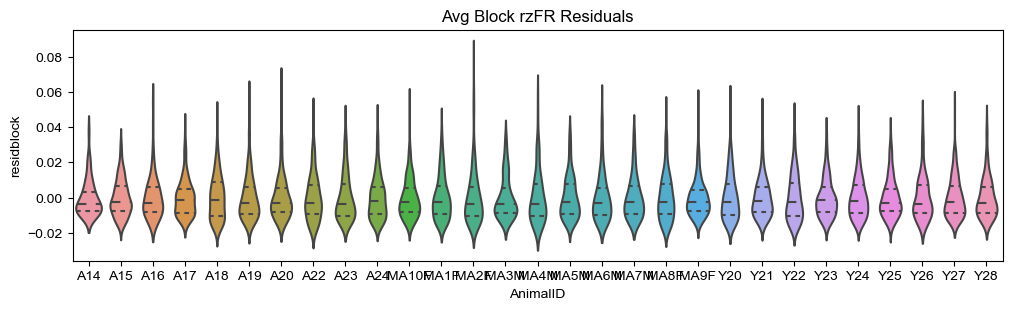

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     rzFRalt  
No. Observations:       6508        Method:                 REML     
No. Groups:             29          Scale:                  0.0013   
Min. group size:        60          Log-Likelihood:         8807.8937
Max. group size:        446         Converged:              Yes      
Mean group size:        224.4                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.086    0.005 18.861 0.000  0.077  0.094
C(AgeGroup)[T.2.0]          0.013    0.007  1.969 0.049  0.000  0.027
C(AgeGroup)[T.3.0]          0.000    0.006  0.076 0.940 -0.012  0.013
C(Sex)[T.M]                 0.001    0.006  0.214 0.831 -0.011  0.014
C(Cohort)[T.D]              0.001   

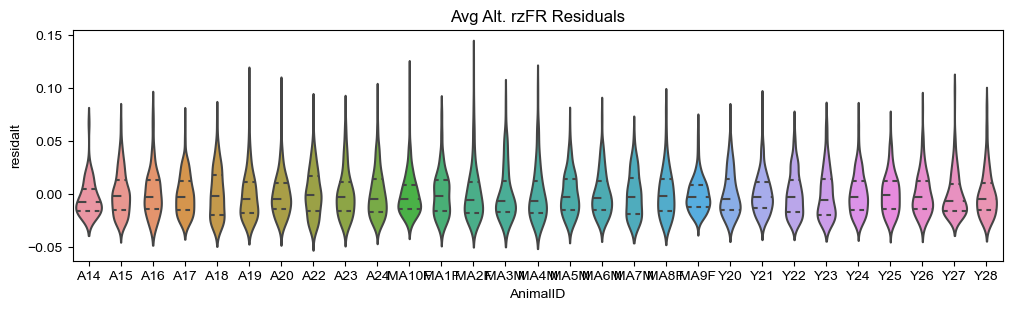

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      deltaFR    
No. Observations:      6508         Method:                  REML       
No. Groups:            29           Scale:                   1421.7771  
Min. group size:       60           Log-Likelihood:          -36491.2597
Max. group size:       446          Converged:               Yes        
Mean group size:       224.4                                            
------------------------------------------------------------------------
                            Coef.   Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------
Intercept                    -2.129    3.659 -0.582 0.561  -9.301  5.043
C(AgeGroup)[T.2.0]           -4.295    5.465 -0.786 0.432 -15.007  6.417
C(AgeGroup)[T.3.0]           -6.679    5.401 -1.237 0.216 -17.266  3.908
C(Sex)[T.M]                   7.079    4.369  1.620 0.105  -1.485 15.

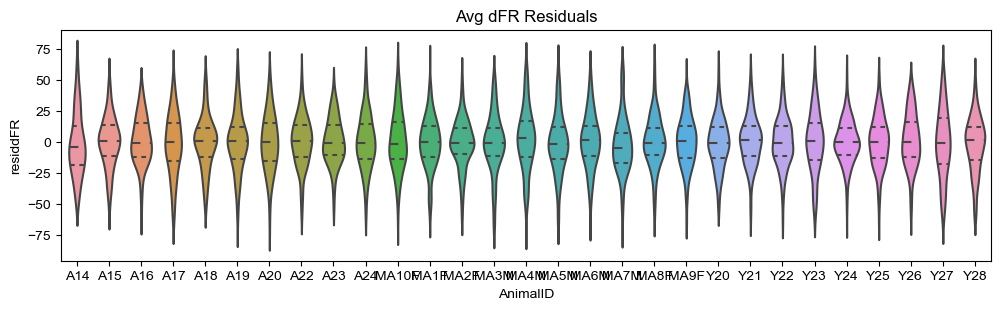

In [24]:
''' LMMs for Grid Reward Zone FR '''        
#gather dependent variables into lists
rzFRblock = list(allblock_grid)
rzFRalt = list(allalt_grid)
deltaFR = list(alldFR_grid)
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, rzFRblock,rzFRalt,deltaFR))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','rzFRblock','rzFRalt','deltaFR'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('rzFRblock ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= False)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block rzFR Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('rzFRalt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. rzFR Residuals')
plt.show()

#Delta Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mdFR = smf.mixedlm('deltaFR ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mdFR.summary())
print(mdFR.wald_test_terms(scalar = False))

df['residdFR'] = mdFR.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residdFR', inner = 'quartile', ax = ax)
plt.title('Avg dFR Residuals')
plt.show()


In [25]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

srzFRAfitted_seg_aged = [[] * r for i in range(r)]
srzFRAfitted_seg_MA = [[] * r for i in range(r)]
srzFRAfitted_seg_young = [[] * r for i in range(r)]
srzFRBfitted_seg_aged = [[] * r for i in range(r)]
srzFRBfitted_seg_MA = [[] * r for i in range(r)]
srzFRBfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            srzFRAfitted_seg_aged[idx] = np.append(srzFRAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            srzFRBfitted_seg_aged[idx] = np.append(srzFRBfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            srzFRAfitted_seg_MA[idx] = np.append(srzFRAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            srzFRBfitted_seg_MA[idx] = np.append(srzFRBfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            srzFRAfitted_seg_young[idx] = np.append(srzFRAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            srzFRBfitted_seg_young[idx] = np.append(srzFRBfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 8

n aged, MA, young mice on day 1 for B
10 10 8

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
9 10 9

n aged, MA, young mice on day 3 for B
9 10 9

n aged, MA, young mice on day 4 for A
9 9 9

n aged, MA, young mice on day 4 for B
9 9 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
7 9 9

n aged, MA, young mice on day 6 for B
7 9 9


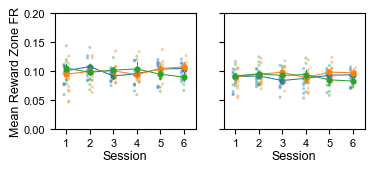

In [26]:
''' Composite Plot of Block & Alt. RZ FR w/ Fitted Session Average Data Points (Reviewer Figure 3C)'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.05,0.1,0.15,0.2])
ax[0].set_ylim([0,0.2])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Reward Zone FR', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.05,0.1,0.15,0.2])
ax[1].set_ylim([0,0.2])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(srzFRAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, srzFRAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], srzFRAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, srzFRAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, srzFRBfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], srzFRBfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, srzFRBfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure3A.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure3A.svg', dpi=400, bbox_inches='tight')
plt.show()

In [27]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mdFRfitted'] = mdFR.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mdFRfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mdFRfitted'])

sdFRAfitted_seg_aged = [[] * r for i in range(r)]
sdFRAfitted_seg_MA = [[] * r for i in range(r)]
sdFRAfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sdFRAfitted_seg_aged[idx] = np.append(sdFRAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sdFRAfitted_seg_MA[idx] = np.append(sdFRAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
        
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sdFRAfitted_seg_young[idx] = np.append(sdFRAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)


n aged, MA, young mice on day 1
10 10 8

n aged, MA, young mice on day 2
10 10 9

n aged, MA, young mice on day 3
9 10 9

n aged, MA, young mice on day 4
9 9 9

n aged, MA, young mice on day 5
8 9 9

n aged, MA, young mice on day 6
7 9 9


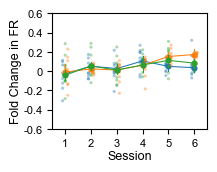

In [28]:
''' Composite Plot of Block & Alt. d FR w/ Fitted Session Average Data Points (Reviewer Figure 3C)'''
f, ax = plt.subplots(1, 1, figsize=(2, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mdFR.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax, scale = 0.5)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([1,2,3,4,5,6])
ax.set_xlim([-0.5,5.5])
ax.set_yticks([-60,-40,-20,0,20,40,60])
ax.set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
ax.set_ylim([-60,60])
ax.tick_params(labelsize = 8)
ax.set_ylabel('Fold Change in FR', fontsize=9, labelpad=1)
ax.set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
#scatter plot LMM-fitted session average data:
for i in range(0,len(sdFRAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1))
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    ax.scatter(sessionAcountfitted_aged[i] + 0.1, sdFRAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax.scatter(sessionAcountfitted_MA[i], sdFRAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax.scatter(sessionAcountfitted_young[i] - 0.1, sdFRAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure3F.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure3F.svg', dpi=400, bbox_inches='tight')
plt.show()

In [29]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each NGS Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
            
        for j, c in enumerate(ngscells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     rzFRblock
No. Observations:       6559        Method:                 REML     
No. Groups:             29          Scale:                  0.0021   
Min. group size:        65          Log-Likelihood:         6650.2444
Max. group size:        446         Converged:              Yes      
Mean group size:        226.2                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.111    0.006 19.528 0.000  0.100  0.122
C(AgeGroup)[T.2.0]          0.020    0.008  2.489 0.013  0.004  0.036
C(AgeGroup)[T.3.0]          0.008    0.008  1.089 0.276 -0.007  0.023
C(Sex)[T.M]                 0.005    0.007  0.713 0.476 -0.008  0.018
C(Cohort)[T.D]             -0.004   

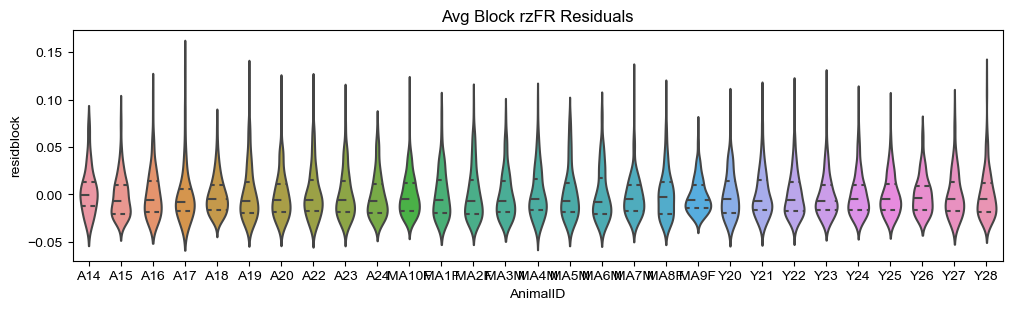

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      rzFRalt  
No. Observations:      6559         Method:                  REML     
No. Groups:            29           Scale:                   0.0020   
Min. group size:       65           Log-Likelihood:          7408.8809
Max. group size:       446          Converged:               Yes      
Mean group size:       226.2                                          
----------------------------------------------------------------------
                           Coef.   Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.096     0.005 17.731 0.000  0.086  0.107
C(AgeGroup)[T.2.0]          0.017     0.008  2.157 0.031  0.002  0.032
C(AgeGroup)[T.3.0]          0.026     0.007  3.535 0.000  0.011  0.040
C(Sex)[T.M]                 0.006     0.007  0.946 0.344 -0.007  0.020
C(Cohort)[T.D]         

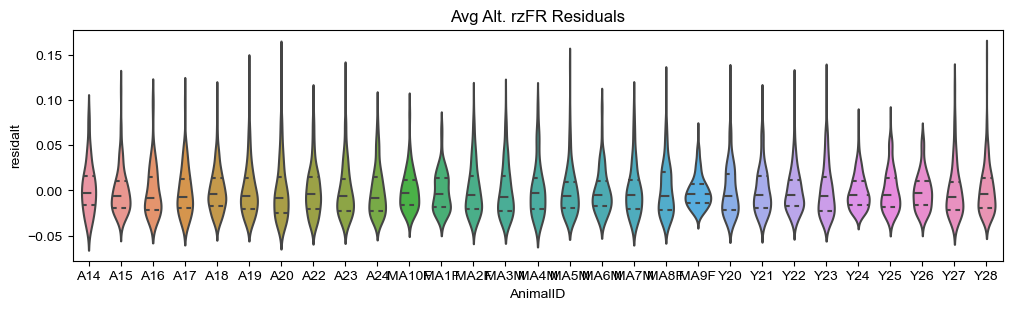

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      deltaFR    
No. Observations:      6559         Method:                  REML       
No. Groups:            29           Scale:                   1257.1801  
Min. group size:       65           Log-Likelihood:          -36388.5911
Max. group size:       446          Converged:               Yes        
Mean group size:       226.2                                            
------------------------------------------------------------------------
                            Coef.   Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------
Intercept                     2.469    3.589  0.688 0.491  -4.564  9.503
C(AgeGroup)[T.2.0]            0.801    5.075  0.158 0.875  -9.146 10.748
C(AgeGroup)[T.3.0]            3.264    5.014  0.651 0.515  -6.564 13.092
C(Sex)[T.M]                  -1.416    3.805 -0.372 0.710  -8.875  6.

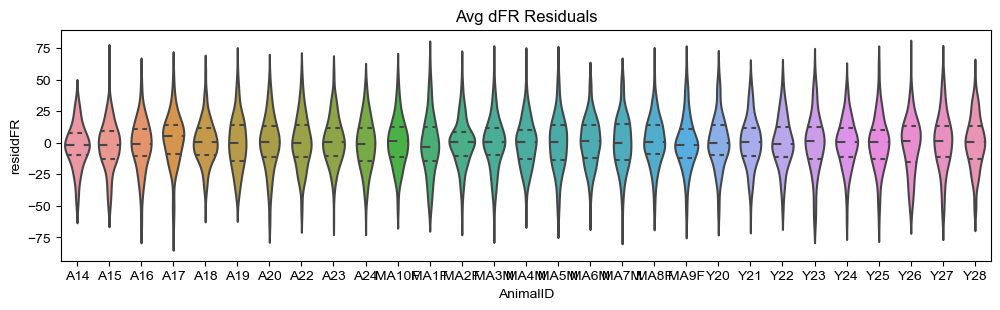

In [30]:
''' LMMs for NGS Reward Zone FR '''        
#gather dependent variables into lists
rzFRblock = list(allblock_ngs)
rzFRalt = list(allalt_ngs)
deltaFR = list(alldFR_ngs)
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, rzFRblock,rzFRalt,deltaFR))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','rzFRblock','rzFRalt','deltaFR'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('rzFRblock ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block rzFR Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('rzFRalt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. rzFR Residuals')
plt.show()

#Delta Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mdFR = smf.mixedlm('deltaFR ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mdFR.summary())
print(mdFR.wald_test_terms(scalar = False))

df['residdFR'] = mdFR.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residdFR', inner = 'quartile', ax = ax)
plt.title('Avg dFR Residuals')
plt.show()

In [31]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

srzFRAfitted_seg_aged = [[] * r for i in range(r)]
srzFRAfitted_seg_MA = [[] * r for i in range(r)]
srzFRAfitted_seg_young = [[] * r for i in range(r)]
srzFRBfitted_seg_aged = [[] * r for i in range(r)]
srzFRBfitted_seg_MA = [[] * r for i in range(r)]
srzFRBfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            srzFRAfitted_seg_aged[idx] = np.append(srzFRAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            srzFRBfitted_seg_aged[idx] = np.append(srzFRBfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            srzFRAfitted_seg_MA[idx] = np.append(srzFRAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            srzFRBfitted_seg_MA[idx] = np.append(srzFRBfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            srzFRAfitted_seg_young[idx] = np.append(srzFRAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            srzFRBfitted_seg_young[idx] = np.append(srzFRBfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 9

n aged, MA, young mice on day 1 for B
10 10 9

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
10 10 9

n aged, MA, young mice on day 3 for B
10 10 9

n aged, MA, young mice on day 4 for A
9 10 9

n aged, MA, young mice on day 4 for B
9 10 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
8 9 9

n aged, MA, young mice on day 6 for B
8 9 9


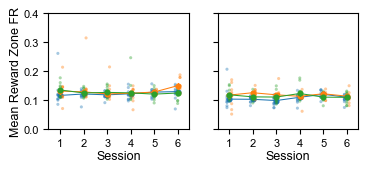

In [32]:
''' Composite Plot of Block & Alt RZ FR w/ Fitted Session Average Data Points (Reviewer Figure 3D)'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.1,0.2,0.3,0.4])
ax[0].set_ylim([0,0.4])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Reward Zone FR', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.1,0.2,0.3,0.4])
ax[1].set_ylim([0,0.4])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(srzFRAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, srzFRAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], srzFRAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, srzFRAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, srzFRBfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], srzFRBfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, srzFRBfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure3B.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure3B.svg', dpi=400, bbox_inches='tight')
plt.show()

In [33]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mdFRfitted'] = mdFR.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mdFRfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mdFRfitted'])

sdFRAfitted_seg_aged = [[] * r for i in range(r)]
sdFRAfitted_seg_MA = [[] * r for i in range(r)]
sdFRAfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sdFRAfitted_seg_aged[idx] = np.append(sdFRAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sdFRAfitted_seg_MA[idx] = np.append(sdFRAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
        
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sdFRAfitted_seg_young[idx] = np.append(sdFRAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)


n aged, MA, young mice on day 1
10 10 9

n aged, MA, young mice on day 2
10 10 9

n aged, MA, young mice on day 3
10 10 9

n aged, MA, young mice on day 4
9 10 9

n aged, MA, young mice on day 5
8 9 9

n aged, MA, young mice on day 6
8 9 9


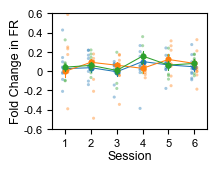

In [34]:
''' Plot of NGS dFR w/ Fitted Session Average Data Points (Reviewer Figure 3G)'''
f, ax = plt.subplots(1, 1, figsize=(2, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mdFR.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax, scale = 0.5)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([1,2,3,4,5,6])
ax.set_xlim([-0.5,5.5])
ax.set_yticks([-60,-40,-20,0,20,40,60])
ax.set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
ax.set_ylim([-60,60])
ax.tick_params(labelsize = 8)
ax.set_ylabel('Fold Change in FR', fontsize=9, labelpad=1)
ax.set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
#scatter plot LMM-fitted session average data:
for i in range(0,len(sdFRAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1))
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    ax.scatter(sessionAcountfitted_aged[i] + 0.1, sdFRAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax.scatter(sessionAcountfitted_MA[i], sdFRAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax.scatter(sessionAcountfitted_young[i] - 0.1, sdFRAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure3G.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure3G.svg', dpi=400, bbox_inches='tight')
plt.show()

In [36]:
''' Find where I will have NaNs'''
nan_idxgrid = np.where((spergrid == 0))[0]
nan_idxngs = np.where((sperngs == 0))[0]
print(nan_idxgrid, nan_idxngs)
print(len(col_session[0]),len(col_session[1]),len(col_session[2]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindgrid = np.setdiff1d(y_sind, nan_idxgrid)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idxgrid)
age_sindgrid = np.setdiff1d(age_sind, nan_idxgrid)

y_sindngs = np.setdiff1d(y_sind, nan_idxngs)
ma_sindngs = np.setdiff1d(ma_sind, nan_idxngs)
age_sindngs = np.setdiff1d(age_sind, nan_idxngs)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idxgrid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

# Adjust colormaps for ngs plots
yidx = []
maidx = []
aidx = []
for i in nan_idxngs:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))

col_session_youngngs = np.delete(col_session_young, list(yidx), axis = 0)
col_session_mangs = np.delete(col_session_MA, list(maidx), axis = 0)
col_session_oldngs = np.delete(col_session_old, list(aidx), axis = 0)
col_sessionngs = [col_session_youngngs, col_session_mangs, col_session_oldngs] 

print(len(col_session_younggrid),len(col_session_youngngs))
print(len(col_session_magrid),len(col_session_mangs))
print(len(col_session_oldgrid),len(col_session_oldngs))

y_sindgrid_sub = np.intersect1d(y_sindgrid,y_sind_sub)
ma_sindgrid_sub = np.intersect1d(ma_sindgrid,ma_sind_sub)
age_sindgrid_sub = np.intersect1d(age_sindgrid,age_sind_sub)
# This will fix session stats & box plots are plotted.

[ 11  24 110 143] []
54 58 55
53 54
57 58
53 55


NameError: name 'y_sind_sub' is not defined


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.08212956827138533 0.00833596773825803 0.1584415705090046 0.09802402774438002
P [Young, MA, Aged, All]: 
0.5587871068318593 0.9509276384706227 0.25715436880773906 0.21318469091783998

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.07760747326138921 0.02298874935361677 0.16600555463412958 0.007098953113131338
P [Young, MA, Aged, All]: 
0.580706685416001 0.8652158400913565 0.23483933196906295 0.9283372855243792

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.1171425241138779 0.10715664621657466 0.21832249412907978 0.13452535538154972
P [Young, MA, Aged, All]: 
0.23174406981279697 0.2564667399059882 0.02455635690219662 0.01507188776563705

n session halves: young, ma, aged
106 114 106


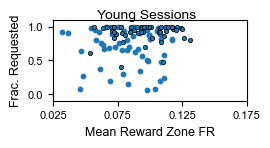

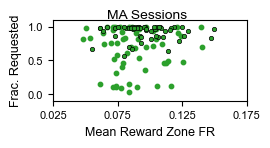

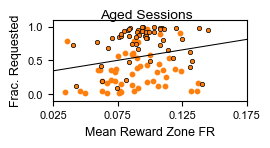

In [39]:
''' Plot Reviewer Figure 3C with Block & Alt. RZ FR Data for Grid Cells'''
allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))

#Linear regression with block data only
res = stats.linregress(sblock_grid[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sblock_grid[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sblock_grid[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sblock_grid[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(salt_grid[y_sindgrid],reqalt_rates[y_sindgrid])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(salt_grid[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(salt_grid[age_sindgrid],reqalt_rates[age_sindgrid])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(salt_grid[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sblock_grid[y_sindgrid],salt_grid[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sblock_grid[ma_sindgrid],salt_grid[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sblock_grid[age_sindgrid],salt_grid[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((sblock_grid[allidx],salt_grid[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid)*2,len(ma_sindgrid)*2,len(age_sindgrid)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(salt_grid[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', s = 10)
ax.scatter(sblock_grid[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.025,0.175])
ax.set_xticks([0.025,0.075,0.125,0.175])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
#ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
plt.savefig(save_folder + 'ReviewerFigure3C_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure3C_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(salt_grid[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', s = 10)
ax.scatter(sblock_grid[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.025,0.175])
ax.set_xticks([0.025,0.075,0.125,0.175])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
#ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
plt.savefig(save_folder + 'ReviewerFigure3C_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure3C_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(salt_grid[age_sindgrid],reqalt_rates[age_sindgrid], color = 'C1', s = 10)
ax.scatter(sblock_grid[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.025,0.175])
ax.set_xticks([0.025,0.075,0.125,0.175])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
plt.savefig(save_folder + 'ReviewerFigure3C_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure3C_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.046646238640552146 -0.01586973746142911 -0.09540801039063379 -0.08186858119830348
P [Young, MA, Aged, All]: 
0.7376701732953781 0.9058800830250142 0.4883748811942614 0.29289334959906094

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.13723173387507523 -0.060612500936079214 0.010504460631993522 -0.0853262071627083
P [Young, MA, Aged, All]: 
0.3223997578669995 0.6512846009113705 0.9393269088300882 0.2729140828624842

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.0886835354493635 -0.038580811570559086 -0.03162175906122613 -0.07024477832904487
P [Young, MA, Aged, All]: 
0.3613992258249322 0.6809396893911883 0.7429530837937308 0.20035540195497797

n session halves: young, ma, aged
108 116 110


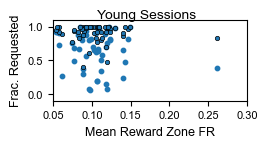

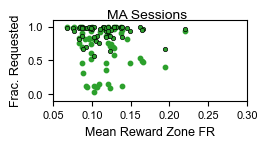

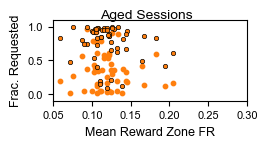

In [40]:
''' Plot Reviewer Figure 3D with Block & Alt. RZ FR Data for NGS Cells'''
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.linregress(sblock_ngs[y_sindngs],reqblock_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sblock_ngs[ma_sindngs],reqblock_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sblock_ngs[age_sindngs],reqblock_rates[age_sindngs])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sblock_ngs[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(salt_ngs[y_sindngs],reqalt_rates[y_sindngs])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(salt_ngs[ma_sindngs],reqalt_rates[ma_sindngs])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(salt_ngs[age_sindngs],reqalt_rates[age_sindngs])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(salt_ngs[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sblock_ngs[y_sindngs],salt_ngs[y_sindngs])),np.hstack((reqblock_rates[y_sindngs],reqalt_rates[y_sindngs])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sblock_ngs[ma_sindngs],salt_ngs[ma_sindngs])),np.hstack((reqblock_rates[ma_sindngs],reqalt_rates[ma_sindngs])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sblock_ngs[age_sindngs],salt_ngs[age_sindngs])),np.hstack((reqblock_rates[age_sindngs],reqalt_rates[age_sindngs])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((sblock_ngs[allidx],salt_ngs[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindngs)*2,len(ma_sindngs)*2,len(age_sindngs)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(salt_ngs[y_sindngs],reqalt_rates[y_sindngs], color = 'C0', s = 10)
ax.scatter(sblock_ngs[y_sindngs],reqblock_rates[y_sindngs], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.05,0.3])
ax.set_xticks([0.05,0.10,0.15,0.2,0.25,0.3])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
#ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
plt.savefig(save_folder + 'ReviewerFigure3D_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure3D_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(salt_ngs[ma_sindngs],reqalt_rates[ma_sindngs], color = 'C2', s = 10)
ax.scatter(sblock_ngs[ma_sindngs],reqblock_rates[ma_sindngs], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.05,0.3])
ax.set_xticks([0.05,0.10,0.15,0.2,0.25,0.3])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
#ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
plt.savefig(save_folder + 'ReviewerFigure3D_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure3D_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(salt_ngs[age_sindngs],reqalt_rates[age_sindngs], color = 'C1', s = 10)
ax.scatter(sblock_ngs[age_sindngs],reqblock_rates[age_sindngs], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.05,0.3])
ax.set_xticks([0.05,0.10,0.15,0.2,0.25,0.3])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
#ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
plt.savefig(save_folder + 'ReviewerFigure3D_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure3D_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

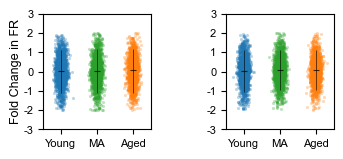

In [41]:
''' Plot change in rz FR over spatial learning (block phase) across age groups for each grid & NGS Cell '''

# plotting params
gs = gridspec.GridSpec(1, 2, wspace=0.7)
f = plt.figure(figsize=(3.75, 1.5))
PLOT_COLORS = ['C0', 'C2', 'C1']
PT_SIZE = 5
PT_LW = 0
BAR_SIZE = 4
BAR_WIDTH = 0.8
LW_PCT = 0.6
SIG_SIZE = 5
LW_SIG = 0.8
POSITIONS = np.asarray([1, 3, 5])

# set jitter
JIT = 0.15
j_y = np.random.randn(grid_n_y) * JIT
j_ma = np.random.randn(grid_n_ma) * JIT
j_aged = np.random.randn(grid_n_aged) * JIT

# CHANGE IN FIRING RATE (GRID)
ax0 = plt.subplot(gs[0])
ax0.scatter(np.full(grid_n_y, POSITIONS[0])+j_y, alldFR_grid[ygridcells], s=PT_SIZE, lw=PT_LW, 
            color='C0', alpha=0.3, zorder=1)
ax0.scatter(np.full(grid_n_ma, POSITIONS[1])+j_ma, alldFR_grid[magridcells], s=PT_SIZE, lw=PT_LW, 
            color='C2', alpha=0.3, zorder=1)
ax0.scatter(np.full(grid_n_aged, POSITIONS[2])+j_aged, alldFR_grid[agedgridcells], s=PT_SIZE, lw=PT_LW, 
            color='C1', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(alldFR_grid[ygridcells]), np.median(alldFR_grid[magridcells]), np.median(alldFR_grid[agedgridcells])])
dFR_5 = np.asarray([np.percentile(alldFR_grid[ygridcells], 5), np.percentile(alldFR_grid[magridcells], 5), np.percentile(alldFR_grid[agedgridcells], 5)])
dFR_95 = np.asarray([np.percentile(alldFR_grid[ygridcells], 95), np.percentile(alldFR_grid[magridcells], 95), np.percentile(alldFR_grid[agedgridcells], 95)])
ax0.plot(POSITIONS[:-1], dFR_medians[:-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.plot(POSITIONS[-1], dFR_medians[-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'k'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax0.tick_params(which='major', labelsize=8)
ax0.set_xticks(POSITIONS)
ax0.set_xticklabels(['Young', 'MA', 'Aged'])
ax0.set_xlim(POSITIONS[0] - 1, POSITIONS[2] + 1)
ax0.set_yticks(np.arange(-300, 310, 100))
ax0.set_yticklabels([-3,-2,-1,0,1,2,3])
ax0.set_ylabel('Fold Change in FR', fontsize=9, labelpad=1)

# set jitter for NGS cells
JIT = 0.15
j_y = np.random.randn(ngs_n_y) * JIT
j_ma = np.random.randn(ngs_n_ma) * JIT
j_aged = np.random.randn(ngs_n_aged) * JIT

# CHANGE IN FIRING RATE (NGS)
ax1 = plt.subplot(gs[1])
ax1.scatter(np.full(ngs_n_y, POSITIONS[0])+j_y, alldFR_ngs[yngscells], s=PT_SIZE, lw=PT_LW, color='C0', alpha=0.3, zorder=1)
ax1.scatter(np.full(ngs_n_ma, POSITIONS[1])+j_ma, alldFR_ngs[mangscells], s=PT_SIZE, lw=PT_LW, color='C2', alpha=0.3, zorder=1)
ax1.scatter(np.full(ngs_n_aged, POSITIONS[2])+j_aged, alldFR_ngs[agedngscells], s=PT_SIZE, lw=PT_LW, color='C1', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(alldFR_ngs[yngscells]), np.median(alldFR_ngs[mangscells]), np.median(alldFR_ngs[agedngscells])])
dFR_5 = np.asarray([np.percentile(alldFR_ngs[yngscells], 5), np.percentile(alldFR_ngs[mangscells], 5), np.percentile(alldFR_ngs[agedngscells], 5)])
dFR_95 = np.asarray([np.percentile(alldFR_ngs[yngscells], 95), np.percentile(alldFR_ngs[mangscells], 95), np.percentile(alldFR_ngs[agedngscells], 95)])
ax1.plot(POSITIONS[:-1], dFR_medians[:-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.plot(POSITIONS[-1], dFR_medians[-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'k'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax1.tick_params(which='major', labelsize=8)
ax1.set_xticks(POSITIONS)
ax1.set_xticklabels(['Young', 'MA', 'Aged'])
ax1.set_xlim(POSITIONS[0] - 1, POSITIONS[2] + 1)
ax1.set_yticks(np.arange(-300, 310, 100))
ax1.set_yticklabels([-3,-2,-1,0,1,2,3])
#ax1.set_ylabel('Fold Change in FR', fontsize=9, labelpad=1)

f.savefig(save_folder + 'ReviewerFigure3E.png', dpi=400, bbox_inches='tight')
f.savefig(save_folder + 'ReviewerFigure3E.svg', dpi=400, bbox_inches='tight')

plt.show()

In [42]:
''' At the cell level, is there any sig. age group difference in the change in reward representation during sessions? '''

#WITHIN EACH AGE GROUP, IS THE CHANGE POST vs. PRE SIG. FOR EACH CELL TYPE?
print('GRID RZ FIRING RATE CHANGE:')
yprepost_stat, yprepost_p = stats.wilcoxon(allpost_grid[ygridcells],allpre_grid[ygridcells],'wilcox', 'greater')
print('n young grid pairs = ' + str(len(allpost_grid[ygridcells])))
print(f'young post vs. pre (signed rank): stat = {yprepost_stat:.4}')
print(f'young post vs. pre (signed rank): p = {yprepost_p:.4}')
maprepost_stat, maprepost_p = stats.wilcoxon(allpost_grid[magridcells],allpre_grid[magridcells],'wilcox', 'greater')
print('n ma pairs = ' + str(len(allpost_grid[magridcells])))
print(f'ma post vs. pre (signed rank): stat = {maprepost_stat:.4}')
print(f'ma post vs. pre (signed rank): p = {maprepost_p:.4}')
agedprepost_stat, agedprepost_p = stats.wilcoxon(allpost_grid[agedgridcells],allpre_grid[agedgridcells],'wilcox', 'greater')
print('n aged pairs = ' + str(len(allpost_grid[agedgridcells])))
print(f'aged post vs. pre (signed rank): stat = {agedprepost_stat:.4}')
print(f'aged post vs. pre (signed rank): p = {agedprepost_p:.4}')
allprepost_stat, allprepost_p = stats.wilcoxon(allpost_grid,allpre_grid,'wilcox', 'greater')
print('n all pairs = ' + str(len(allpost_grid)))
print(f'all post vs. pre (signed rank): stat = {allprepost_stat:.4}')
print(f'all post vs. pre (signed rank): p = {allprepost_p:.4}')

print('\nNGS RZ FIRING RATE CHANGE:')
yprepost_stat, yprepost_p = stats.wilcoxon(allpost_ngs[yngscells],allpre_ngs[yngscells], 'wilcox','greater')
print('n young ngs pairs = ' + str(len(allpost_ngs[yngscells])))
print(f'young post vs. pre (signed rank): stat = {yprepost_stat:.4}')
print(f'young post vs. pre (signed rank): p = {yprepost_p:.4}')
maprepost_stat, maprepost_p = stats.wilcoxon(allpost_ngs[mangscells], allpre_ngs[mangscells],'wilcox', 'greater')
print('n ma pairs = ' + str(len(allpost_ngs[mangscells])))
print(f'ma post vs. pre (signed rank): stat = {maprepost_stat:.4}')
print(f'ma post vs. pre (signed rank): p = {maprepost_p:.4}')
agedprepost_stat, agedprepost_p = stats.wilcoxon(allpost_ngs[agedngscells], allpre_ngs[agedngscells],'wilcox', 'greater')
print('n aged pairs = ' + str(len(allpost_ngs[agedngscells])))
print(f'aged post vs. pre (signed rank): stat = {agedprepost_stat:.4}')
print(f'aged post vs. pre (signed rank): p = {agedprepost_p:.4}')
allprepost_stat, allprepost_p = stats.wilcoxon(allpost_ngs,allpre_ngs,'wilcox', 'greater')
print('n all pairs = ' + str(len(allpost_ngs)))
print(f'all post vs. pre (signed rank): stat = {allprepost_stat:.4}')
print(f'all post vs. pre (signed rank): p = {allprepost_p:.4}')

#AGE GROUP DIFFERENCES WITHIN CELL TYPE
# grid firing rate change
print('\nGRID CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(alldFR_grid[ygridcells], alldFR_grid[magridcells], alldFR_grid[agedgridcells])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')
yvsma_stat, yvsma_p = stats.ranksums(alldFR_grid[ygridcells], alldFR_grid[magridcells])
print(f'young vs. MA (rank sums): p = {yvsma_p:.4}')
yvsaged_stat, yvsaged_p = stats.ranksums(alldFR_grid[ygridcells], alldFR_grid[agedgridcells])
print(f'young vs. aged (rank sums): p = {yvsaged_p:.4}')
agedvsma_stat, agedvsma_p = stats.ranksums(alldFR_grid[agedgridcells], alldFR_grid[magridcells])
print(f'aged vs. MA (rank sums): p = {agedvsma_p:.4}')

# ngs firing rate change
print('\nNGS CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(alldFR_ngs[yngscells], alldFR_ngs[mangscells], alldFR_ngs[agedngscells])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')
yvsma_stat, yvsma_p = stats.ranksums(alldFR_ngs[yngscells], alldFR_ngs[mangscells])
print(f'young vs. MA (rank sums): p = {yvsma_p:.4}')
yvsaged_stat, yvsaged_p = stats.ranksums(alldFR_ngs[yngscells], alldFR_ngs[agedngscells])
print(f'young vs. aged (rank sums): p = {yvsaged_p:.4}')
agedvsma_stat, agedvsma_p = stats.ranksums(alldFR_ngs[agedngscells], alldFR_ngs[mangscells])
print(f'aged vs. MA (rank sums): p = {agedvsma_p:.4}')

#STATS on dFR (MEAN ± SEM) for GRID CELLS
print('\nGRID CELL dFR INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(alldFR_grid[ygridcells]),3)) + ' ± '  + str(np.round(stats.sem(alldFR_grid[ygridcells]),3)))
print(str(np.round(np.mean(alldFR_grid[magridcells]),3)) + ' ± '  + str(np.round(stats.sem(alldFR_grid[magridcells]),3)))
print(str(np.round(np.mean(alldFR_grid[agedgridcells]),3)) + ' ± '  + str(np.round(stats.sem(alldFR_grid[agedgridcells]),3)))

print('\nNGS CELL dFR INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(alldFR_ngs[yngscells]),3)) + ' ± '  + str(np.round(stats.sem(alldFR_ngs[yngscells]),3)))
print(str(np.round(np.mean(alldFR_ngs[mangscells]),3)) + ' ± '  + str(np.round(stats.sem(alldFR_ngs[mangscells]),3)))
print(str(np.round(np.mean(alldFR_ngs[agedngscells]),3)) + ' ± '  + str(np.round(stats.sem(alldFR_ngs[agedngscells]),3)))

print('\nPost vs. Pre rz FR, All Cells:')
print('Pre Grid Cells, Mean ± SEM')
print(str(np.round(np.mean(allpre_grid),4)) + ' ± '  + str(np.round(stats.sem(allpre_grid),4)))
print('Pre NGS Cells, Mean ± SEM')
print(str(np.round(np.mean(allpre_ngs),4)) + ' ± '  + str(np.round(stats.sem(allpre_ngs),4)))

print('Post Grid Cells, Mean ± SEM')
print(str(np.round(np.mean(allpost_grid),4)) + ' ± '  + str(np.round(stats.sem(allpost_grid),4)))
print('Post NGS Cells, Mean ± SEM')
print(str(np.round(np.mean(allpost_ngs),4)) + ' ± '  + str(np.round(stats.sem(allpost_ngs),4)))


GRID RZ FIRING RATE CHANGE:
n young grid pairs = 2441
young post vs. pre (signed rank): stat = 1.405e+06
young post vs. pre (signed rank): p = 0.01389
n ma pairs = 2035
ma post vs. pre (signed rank): stat = 1.005e+06
ma post vs. pre (signed rank): p = 0.2495
n aged pairs = 2032
aged post vs. pre (signed rank): stat = 9.29e+05
aged post vs. pre (signed rank): p = 8.817e-05
n all pairs = 6508
all post vs. pre (signed rank): stat = 9.93e+06
all post vs. pre (signed rank): p = 1.311e-05

NGS RZ FIRING RATE CHANGE:
n young ngs pairs = 2154
young post vs. pre (signed rank): stat = 1.095e+06
young post vs. pre (signed rank): p = 0.02248
n ma pairs = 2347
ma post vs. pre (signed rank): stat = 1.299e+06
ma post vs. pre (signed rank): p = 0.01594
n aged pairs = 2058
aged post vs. pre (signed rank): stat = 9.512e+05
aged post vs. pre (signed rank): p = 6.006e-05
n all pairs = 6559
all post vs. pre (signed rank): stat = 9.991e+06
all post vs. pre (signed rank): p = 5.905e-07

GRID CHANGE IN FIRING


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.33821405852104797 0.24833755880808078 0.1396600243402922 0.19991070775621664
P [Young, MA, Aged, All]: 
0.01324930635626367 0.062509278223426 0.31857290670993793 0.010511660942484648


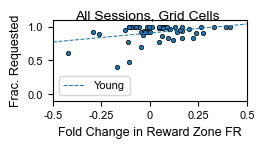

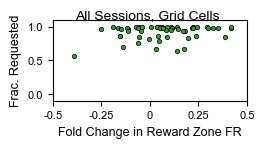

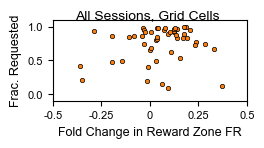


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.16186877557138837 0.25144629081908826 0.021789286101930025 0.11362530626702766
P [Young, MA, Aged, All]: 
0.24224809619032686 0.05691198502871421 0.8745350225901534 0.14372116896281453


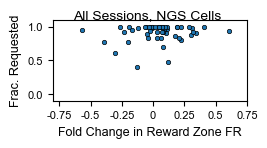

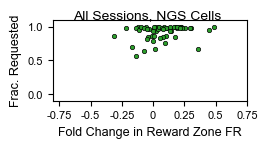

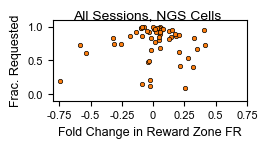

In [49]:
''' Assess & plot correlation of block performance vs. block dFR (pooling age groups) for grid & NGS cells, separately '''

#GRID CELLS
allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))

#Linear regression with block data only
res = stats.linregress(sdFR_grid[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

#Test outlier omission...
#res = stats.linregress(sdFR_grid[y_sindgrid][np.where(sdFR_grid[y_sindgrid] != np.min(sdFR_grid[y_sindgrid]))[0]],reqblock_rates[y_sindgrid][np.where(sdFR_grid[y_sindgrid] != np.min(sdFR_grid[y_sindgrid]))[0]])
#yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sdFR_grid[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sdFR_grid[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sdFR_grid[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Plot delta FR over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, Grid Cells', fontsize = 10)
ax.scatter(sdFR_grid[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-50,50])
ax.set_xticks([-50,-25,0,25,50])
ax.set_xticklabels([-0.50,-0.25,0,0.25,0.5])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', linewidth = 0.75, label = 'Young')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure3H_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure3H_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, Grid Cells', fontsize = 10)
ax.scatter(sdFR_grid[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-50,50])
ax.set_xticks([-50,-25,0,25,50])
ax.set_xticklabels([-0.50,-0.25,0,0.25,0.5])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
plt.savefig(save_folder + 'ReviewerFigure3H_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure3H_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, Grid Cells', fontsize = 10)
ax.scatter(sdFR_grid[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-50,50])
ax.set_xticks([-50,-25,0,25,50])
ax.set_xticklabels([-0.50,-0.25,0,0.25,0.5])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
plt.savefig(save_folder + 'ReviewerFigure3H_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure3H_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#NGS CELLS
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.linregress(sdFR_ngs[y_sindngs],reqblock_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sdFR_ngs[ma_sindngs],reqblock_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sdFR_ngs[age_sindngs],reqblock_rates[age_sindngs])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sdFR_ngs[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Plot delta FR over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, NGS Cells', fontsize = 10)
ax.scatter(sdFR_ngs[y_sindngs],reqblock_rates[y_sindngs], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-80,75])
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.set_xticklabels([-0.75,-0.50,-0.25,0,0.25,0.5,0.75])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, allslope1*X_plot + allint1, '--', color = 'k', linewidth = 0.75, label = 'All Ages')
#ax.plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', linewidth = 0.75, label = 'Young')
plt.savefig(save_folder + 'ReviewerFigure3I_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure3I_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, NGS Cells', fontsize = 10)
ax.scatter(sdFR_ngs[ma_sindngs],reqblock_rates[ma_sindngs], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-80,75])
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.set_xticklabels([-0.75,-0.50,-0.25,0,0.25,0.5,0.75])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, allslope1*X_plot + allint1, '--', color = 'k', linewidth = 0.75, label = 'All Ages')
#ax.plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', linewidth = 0.75, label = 'Young')
plt.savefig(save_folder + 'ReviewerFigure3I_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure3I_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, NGS Cells', fontsize = 10)
ax.scatter(sdFR_ngs[age_sindngs],reqblock_rates[age_sindngs], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-80,75])
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.set_xticklabels([-0.75,-0.50,-0.25,0,0.25,0.5,0.75])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, allslope1*X_plot + allint1, '--', color = 'k', linewidth = 0.75, label = 'All Ages')
#ax.plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', linewidth = 0.75, label = 'Young')
plt.savefig(save_folder + 'ReviewerFigure3I_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure3I_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

# Analysis Summary

First, we assessed to what extent age and session predicted reward zone FR in each SM task phase using linear mixed effects models, fitted separately for grid (Reviewer Figure 3A) and NGS (Reviewer Figure 3B) cells. Grid cell reward zone FR during the block phase did not differ across age groups and was not predicted by age, sex, or session (mean ± SEM block trial reward zone FR: young = 0.101 ± 0.001, MA = 0.099 ± 0.002, aged = 0.100 ± 0.002; Kruskal Wallis H-test, H = 5.578, p = 0.061). Grid alternation reward zone representation also did not differ across age groups and was also not predicted by age group, sex, cohort, or session, consistent with a similar lack of significant age group differences (alternation trial reward zone FR: young = 0.090 ± 0.001, MA = 0.091 ± 0.001, aged = 0.095 ± 0.001; Kruskal Wallis H-test, H = 5.714, p = 0.057). Both models of NGS cell reward zone FR over block and alternation trials showed that age and session predicted NGS reward zone FR (block trial reward zone FR: young = 0.122 ± 0.002, MA = 0.126 ± 0.002, aged = 0.128 ± 0.002; alternation trial reward zone FR: young = 0.107 ± 0.002, MA = 0.113 ± 0.002, aged = 0.119 ± 0.002) (Reviewer Figure 3B). These results suggest that grid reward zone FR does not change over sessions or with age in the SM task. By contrast, NGS block reward zone FR increases modestly over sessions for all age groups, consistent with the interpretation that age does not impair increases in NGS cell reward zone FR over task experience. 

We next examined the relationship between grid and NGS reward zone FR and SM task performance, finding no significant relationships between SM performance and reward zone FR for either cell type that were consistent across age groups (Reviewer Figure 3C-D). Importantly, we contend that this negative result does not contradict the relationship between reward memory retention and the extent of grid reward zone FR modulation reported by Boccara et al. in 2019. This is because Boccara and colleagues assessed reward zone FR changes at short timescales (i.e. between ~25 min probe sessions pre- and post-reward learning on the same day), rather than over sessions, in relation to one-shot spatial learning of reward locations. Therefore, we next calculated the fold change in normalized reward zone FR between the first 5 and last 5 trials in each context in the block phase of the SM task as a closer proxy of the comparison pre- and post-probe reward zone FR. 

Importantly, consistent with Butler et al. 2019 and Bocarra et al. 2019, we observed that grid and NGS cell block reward zone FR increased within sessions (n = 6508 grid cell pairs, mean ± SEM normalized reward zone FR, post vs. pre, 0.1001 ± 0.0009 vs. 0.0987 ± 0.0009, Wilcoxon signed-rank test, p < 0.0001) (n = 6559 NGS cell pairs, mean ± SEM reward zone FR, post vs. pre, 0.1248 ± 0.0012 vs. 0.1248 ± 0.0011, Wilcoxon signed-rank test, p < 0.0001). We also observed this significant increase in reward zone FR in most individual age groups (Reviewer Figure 3E). The change in grid and NGS cell block reward zone FR within sessions did not differ significantly across age groups. To investigate this further, we used nested linear effects models to characterize age group, session, sex, and cohort effects on the fold change in block reward zone FR for each cell type (Reviewer Figure 3F-G). These models confirmed the lack of age effect on increased reward zone FR with learning and revealed that additional sessions led to more change in reward zone FR for only grid cells within each block phase, unmodulated by age effects. Finally, for both grid and NGS cells, we assessed if the change in reward zone FR across block trials related to block task performance within each age group (Reviewer Figure 3H-I) (most similar to Figure 3F of Boccara et al. 2019). Only the extent of young grid cell reward zone FR change related to block performance. However, this was a partially outlier-dependent relationship; if the session with the lowest block performance and reward zone FR change was computationally ablated, the observed relationship was much weaker (r = 0.28, p = 0.048).

Ultimately, these results suggest that grid and NGS reward zone FR changes over sessions and within sessions were not neural correlates of Split Maze performance. We hypothesize that this difference from previously reported relationships may arise from several factors. First, by examining grid and NGS cell firing in 1D VR, we effectively took a slice through each cell’s 2D firing field landscape (Yoon et al., 2016). This limitation may obscure subtle effects like proximal firing field attraction to reward zones or increases in reward zone-proximal firing rate. Second, the Split Maze was designed to assess context-dependent spatial memory in relation to the quality and flexibility of MEC spatial coding, rather than the relationship of reward-related neural firing and learning in cue invariant environments as in the work Butler and Boccara. This raises the possibilities that context changes modulate in MEC grid and NGS firing more strongly than reward experience, in the SM task or in general. As such, reward-mediated changes in firing rate may also be obscured by context-dependent global remapping (see Figure S2G-J). Third and finally, the Butler and Boccara et al. 2019 tasks recorded in the same environments during rewarded and unrewarded task phases, whereas rewarded locations were present on all Split Maze VR trials. Additionally, in Boccara et al. 2019, reward locations changed across sessions, while they did not in the Split Maze. This prevented us from recapitulating the direct comparison of spatial cell firing near rewards with that at the same locations during random foraging (as in Butler et al.). Similarly, as we did not record the same cells across sessions, we could not rigorously assess distortions in reward-proximal grid fields post vs. pre-learning across changing rewarded locations (as in Boccara et al.). Moreover, it is highly plausible that modulation of MEC spatial cell firing at rewarded locations, at least partially, requires a type of prediction error arising from the omission of expected rewards, which is lacking in the Split Maze.